In [1]:
import re
import numpy as np
import matplotlib
from copy import copy
from tqdm import tqdm
from typing import Text
from matplotlib import pyplot as plt

In [2]:
TOP,    YELLOW  = 0, 0
LEFT,   ORANGE  = 1, 1
FRONT,  BLUE    = 2, 2
RIGHT,  RED     = 3, 3
BACK,   GREEN   = 4, 4
DOWN,   WHITE   = 5, 5

FACES = [TOP, LEFT, FRONT, RIGHT, BACK, DOWN]
FACE_COLORS = [YELLOW, ORANGE, BLUE, RED, GREEN, WHITE]

FACE_MAPPING = {
    TOP: "TOP",
    LEFT: "LEFT",
    FRONT: "FRONT",
    RIGHT: "RIGHT",
    BACK: "BACK",
    DOWN: "DOWN",
}

COLOR_MAPPING = {
    YELLOW: "YELLOW",
    ORANGE: "ORANGE",
    BLUE: "BLUE",
    RED: "RED",
    GREEN: "GREEN",
    WHITE: "WHITE",
}

In [3]:
# Consider a coordinate system placed on the center of the cube
# X-axis is perpendicular to the right face
# Y-axis is perpendicular to the top face
# Z-axis is perpendicular to the front face
# Cubies are identified by points in this coordinate system

CORNER_CUBIES = {
    (-1, 1, 1): [(LEFT, 0, 2), (TOP, 2, 0), (FRONT, 0, 0)],
    (1, 1, 1): [(RIGHT, 0, 0), (TOP, 2, 2), (FRONT, 0, 2)],
    (-1, -1, 1): [(LEFT, 2, 2), (DOWN, 0, 0), (FRONT, 2, 0)],
    (1, -1, 1): [(RIGHT, 2, 0), (DOWN, 0, 2), (FRONT, 2, 2)],
    (1, 1, -1): [(RIGHT, 0, 2), (TOP, 0, 2), (BACK, 0, 0)],
    (-1, 1, -1): [(LEFT, 0, 0), (TOP, 0, 0), (BACK, 0, 2)],
    (1, -1, -1): [(RIGHT, 2, 2), (DOWN, 2, 2), (BACK, 2, 0)],
    (-1, -1, -1): [(LEFT, 2, 0), (DOWN, 2, 0), (BACK, 2, 2)],
}

BORDER_CUBIES = {
    (-1, 0, 1): [(LEFT, 1, 2), (FRONT, 1, 0)],
    (0, 1, 1): [(TOP, 2, 1), (FRONT, 0, 1)],
    (1, 0, 1): [(RIGHT, 1, 0), (FRONT, 1, 2)],
    (0, -1, 1): [(DOWN, 0, 1), (FRONT, 2, 1)],
    (-1, 0, -1): [(LEFT, 1, 0), (BACK, 1, 2)],
    (0, 1, -1): [(TOP, 0, 1), (BACK, 0, 1)],
    (1, 0, -1): [(RIGHT, 1, 2), (BACK, 1, 0)],
    (0, -1, -1): [(DOWN, 2, 1), (BACK, 2, 1)],
    (-1, 1, 0): [(LEFT, 0, 1), (TOP, 1, 0)],
    (-1, -1, 0): [(LEFT, 2, 1), (DOWN, 1, 0)],
    (1, 1, 0): [(RIGHT, 0, 1), (TOP, 1, 2)],
    (1, -1, 0): [(RIGHT, 2, 1), (DOWN, 1, 2)],
}

CENTER_CUBIES = {
    (0, 1, 0): [(TOP, 1, 1)],
    (-1, 0, 0): [(LEFT, 1, 1)],
    (0, 0, 1): [(FRONT, 1, 1)],
    (1, 0, 0): [(RIGHT, 1, 1)],
    (0, 0, -1): [(BACK, 1, 1)],
    (0, -1, 0): [(DOWN, 1, 1)],
}

ALL_CUBIES = {**CORNER_CUBIES, **BORDER_CUBIES, **CENTER_CUBIES}

In [66]:
MOVEMENTS = "R,L,F,B,U,D,R',L',F',B',U',D',R2,L2,F2,B2,U2,D2".split(",")
# MOVEMENTS += [f"{m1} {m2}" for m1 in MOVEMENTS for m2 in MOVEMENTS]
print(MOVEMENTS)

['R', 'L', 'F', 'B', 'U', 'D', "R'", "L'", "F'", "B'", "U'", "D'", 'R2', 'L2', 'F2', 'B2', 'U2', 'D2']


In [5]:
def createSolvedCube():
    cube = np.zeros((6, 3, 3))
    for face in FACES:
        color = FACE_COLORS[face]
        for row in range(3):
            for column in range(3):
                cube[face, row, column] = color
    return cube

In [6]:
def showCube(cube: np.ndarray):
    cmap = matplotlib.colors.ListedColormap(["black", *[COLOR_MAPPING[color].lower() for color in FACE_COLORS]])
    img = np.zeros((9, 12))
    for f, face in enumerate([LEFT, FRONT, RIGHT, BACK]):
        img[3:6, f*3:(f+1)*3] = cube[face]+1
    for f, face in enumerate([TOP, FRONT, DOWN]):
        img[f*3:(f+1)*3, 3:6] = cube[face]+1
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap = cmap)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 12, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color = "black", linewidth = 1)

In [7]:
def turnRightFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, FRONT, DOWN, BACK] if isClockWise else [DOWN, FRONT, TOP, BACK]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], :, -1])
        turnedCube[facesOrder[0], :, -1] = turnedCube[facesOrder[1], :, -1]
        turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], :, -1]
        turnedCube[facesOrder[2], :, -1] = turnedCube[facesOrder[3], :, 0][::-1]
        turnedCube[facesOrder[3], :, 0] = tmp[::-1]
        newFace = copy(turnedCube[RIGHT])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[RIGHT, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[RIGHT, :, 2-i]
        turnedCube[RIGHT] = newFace
    return turnedCube

In [8]:
def turnLeftFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [DOWN, FRONT, TOP, BACK] if isClockWise else [TOP, FRONT, DOWN, BACK]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], :, 0])
        turnedCube[facesOrder[0], :, 0] = turnedCube[facesOrder[1], :, 0]
        turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], :, 0]
        turnedCube[facesOrder[2], :, 0] = turnedCube[facesOrder[3], :, -1][::-1]
        turnedCube[facesOrder[3], :, -1] = tmp[::-1]
        newFace = copy(turnedCube[LEFT])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[LEFT, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[LEFT, :, 2-i]
        turnedCube[LEFT] = newFace
    return turnedCube

In [9]:
def turnTopFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [FRONT, RIGHT, BACK, LEFT] if isClockWise else [FRONT, LEFT, BACK, RIGHT]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], 0, :])
        turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], 0, :]
        turnedCube[facesOrder[1], 0, :] = turnedCube[facesOrder[2], 0, :]
        turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], 0, :]
        turnedCube[facesOrder[3], 0, :] = tmp
        newFace = copy(turnedCube[TOP])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[TOP, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[TOP, :, 2-i]
        turnedCube[TOP] = newFace
    return turnedCube

In [10]:
def turnDownFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [FRONT, LEFT, BACK, RIGHT] if isClockWise else [FRONT, RIGHT, BACK, LEFT]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], -1, :])
        turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], -1, :]
        turnedCube[facesOrder[1], -1, :] = turnedCube[facesOrder[2], -1, :]
        turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], -1, :]
        turnedCube[facesOrder[3], -1, :] = tmp
        newFace = copy(turnedCube[DOWN])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[DOWN, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[DOWN, :, 2-i]
        turnedCube[DOWN] = newFace
    return turnedCube

In [11]:
def turnFrontFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, LEFT, DOWN, RIGHT] if isClockWise else [TOP, RIGHT, DOWN, LEFT]
    for turn in range(nRotations):
        newFace = copy(turnedCube[FRONT])
        if isClockWise:
            tmp = copy(turnedCube[facesOrder[0], -1, :])
            turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], :, -1][::-1]
            turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], 0, :]
            turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], :, 0][::-1]
            turnedCube[facesOrder[3], :, 0] = tmp
            for i in range(3):
                newFace[i, :] = turnedCube[FRONT, :, i][::-1]
        else:
            tmp = copy(turnedCube[facesOrder[0], -1, :])
            turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], :, 0]
            turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], 0, :][::-1]
            turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], :, -1]
            turnedCube[facesOrder[3], :, -1] = tmp[::-1]
            for i in range(3):
                newFace[i, :] = turnedCube[FRONT, :, 2-i]
        turnedCube[FRONT] = newFace
    return turnedCube

In [12]:
def turnBackFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, RIGHT, DOWN, LEFT] if isClockWise else [TOP, LEFT, DOWN, RIGHT]
    for turn in range(nRotations):
        newFace = copy(turnedCube[BACK])
        if isClockWise:
            tmp = copy(turnedCube[facesOrder[0], 0, :])
            turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], :, -1]
            turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], -1, :][::-1]
            turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], :, 0]
            turnedCube[facesOrder[3], :, 0] = tmp[::-1]
            for i in range(3):
                newFace[i, :] = turnedCube[BACK, :, i][::-1]
        else:
            tmp = copy(turnedCube[facesOrder[0], 0, :])
            turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], :, 0][::-1]
            turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], -1, :]
            turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], :, -1][::-1]
            turnedCube[facesOrder[3], :, -1] = tmp
            for i in range(3):
                newFace[i, :] = turnedCube[BACK, :, 2-i]
        turnedCube[BACK] = newFace
    return turnedCube

In [13]:
def validateMovement(movement: str):
    if len(movement) > 2:
        raise ValueError("Movement can not be a string with more than 2 characters.")

    if len(movement) == 2:
        secondChar = movement[1]
        if secondChar not in ["'", "2"]:
            raise ValueError(f"{movement} is not a valid movement.")

    return True

In [14]:
def decodeMovement(movement: str):
    validateMovement(movement)

    face = movement[0].upper()
    if face not in ["U", "D", "L", "R", "F", "B"]:
        raise ValueError(f"{face} is not a valid face.")
    turnFunction = {
        "U": turnTopFace, "D": turnDownFace, "R": turnRightFace,
        "L": turnLeftFace, "F": turnFrontFace, "B": turnBackFace,
    }[face]

    angle = 90
    isClockWise = True

    if len(movement) == 2:
        secondChar = movement[1]
        angle = 180 if secondChar == "2" else angle
        isClockWise = False if secondChar == "'" else True
    
    return (turnFunction, angle, isClockWise)

In [15]:
def decodeMovements(movements: str):
    movements = re.sub("\s*X", "", movements)
    movements = movements.strip().split(" ")
    decodedMovements = []
    for movement in movements:
        if movement != "":
            decodedMovements.append(decodeMovement(movement))
    return decodedMovements

In [16]:
def reverseMovements(movements: str):
    decodedMovements = decodeMovements(movements)
    movements = movements.strip().split(" ")
    reverse = []
    for movement, decoded in zip(movements, decodedMovements):
        faceChar = movement[0]
        angle = decoded[1]
        isClockWise = not decoded[2]
        movementString = faceChar
        movementString = f"{movementString}2" if angle == 180 else f"{movementString}'" if not isClockWise else movementString
        reverse.append(movementString)
    return " ".join(reverse[::-1])

In [17]:
def turn(cube: np.ndarray, movements: str):
    decodedMovements = decodeMovements(movements)
    
    turnedCube = copy(cube)
    for turnFunction, angle, isClockWise in decodedMovements:
        turnedCube = turnFunction(turnedCube, angle = angle, isClockWise = isClockWise)

    return turnedCube

In [18]:
def sampleCube(nSamples = 1, shuffleIterations = 500):
    cube = createSolvedCube()
    sample = []
    for i in range(nSamples):
        movements = " ".join(np.random.choice(MOVEMENTS, shuffleIterations))
        newCube = turn(cube, movements)

        sample.append([newCube, movements])
    return sample

# **Simulated Annealing Implementation**

In [56]:
def simulatedAnnealing(
    initialState, 
    neighborsFunction, 
    utilityFunction, 
    initialTemperature = 5000, 
    simulationSteps = 100,
    tolerance = 1e-5,
    annealingStrat = "exponential",
    beta = 0.95
):
    curState = initialState
    curScore = utilityFunction(curState)

    bestState = curState
    bestScore = curScore

    curTemperature = initialTemperature
    while curTemperature > tolerance:
        for step in range(simulationSteps):
            candidateNeighborState = neighborsFunction(curState)
            candidateNeighborScore = utilityFunction(candidateNeighborState)
            
            delta = candidateNeighborScore - curScore
            transitionProb = min(1, np.exp(-(delta)/curTemperature))
            if np.random.binomial(n = 1, p = transitionProb) == 1:
                curState = candidateNeighborState
                curScore = candidateNeighborScore
            
                if curScore <= bestScore:
                    bestState = curState
                    bestScore = curScore

        curTemperature = (curTemperature * beta) if annealingStrat == "exponential" else (curTemperature - beta)
    return bestState, bestScore

# **Neighbors**

In [57]:
def singleMovementNeighbors(cube: np.ndarray) -> np.ndarray:
    sampledMovement = np.random.choice(MOVEMENTS, 1).item()
    newCube = turn(cube, movements = sampledMovement)
    return newCube

# **Utility**

## **Total Incorrect Colors**

In [75]:
def totalIncorrectColors(cube: np.ndarray):
    totalIncorrect = 0
    for face in FACES:
        cubeFaceColors = cube[face]
        faceIncorrectColorsCount = (cubeFaceColors != FACE_COLORS[face]).sum()
        totalIncorrect += faceIncorrectColorsCount
    return totalIncorrect

# **Experiments**

In [59]:
np.random.seed(10)
cubesSample = sampleCube(nSamples = 200)

In [70]:
best = []
for cube, movements in tqdm(cubesSample): 
    bestSolution, bestScore = simulatedAnnealing(
        cube, 
        singleMovementNeighbors,
        totalIncorrectColors,
        initialTemperature = 5000, 
        simulationSteps = 100,
        tolerance = 1e-5,
        annealingStrat = "exponential",
        beta = 0.95
    )
    best.append([bestSolution, bestScore])
    print(bestScore)

100%|██████████| 1/1 [00:02<00:00,  2.68s/it]

6


In [72]:
np.min([i[1] for i in best])

6

In [ ]:
# This function may be useful for sampling cubes at random (uniformly)
def uniformMovementsSampling(sequenceSize = 200, nSamples = 1000):
    clockwiseMovements = ["R", "L", "U", "D", "F", "B"]
    counterClockwiseMovements = [f"{movement}'" for movement in clockwiseMovements]
    doubleMovements = [f"{movement}2" for movement in clockwiseMovements]
    allowedMovements = [*clockwiseMovements, *counterClockwiseMovements, *doubleMovements]
    sampledMovements = []
    for sample in range(nSamples):
        sampledSequence = np.random.choice(allowedMovements, sequenceSize, replace = True)
        sampledSequence = " ".join(sampledSequence)
        sampledMovements.append(sampledSequence)
    return sampledMovements

In [19]:
cube = createSolvedCube()

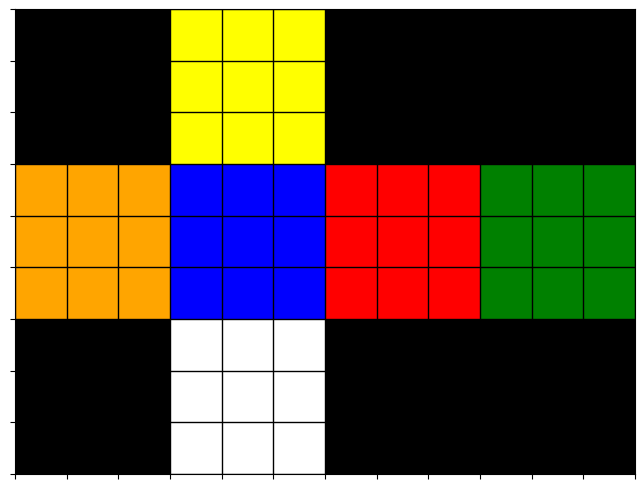

In [20]:
showCube(cube)

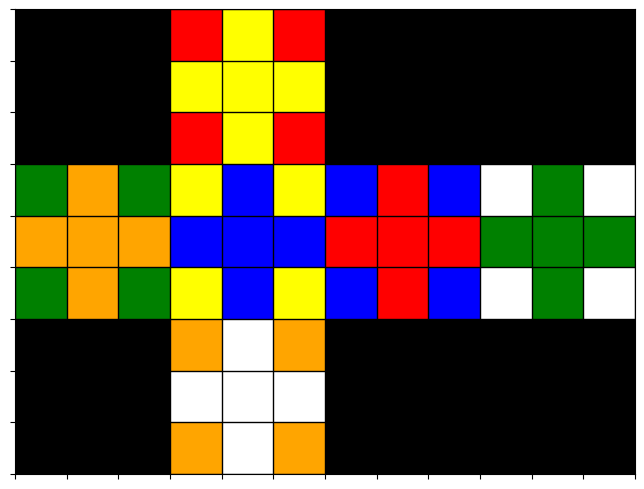

In [21]:
showCube(turn(cube, movements = "R2 L' D F2 R' D' R' L U' D R D B2 R' U D2"))

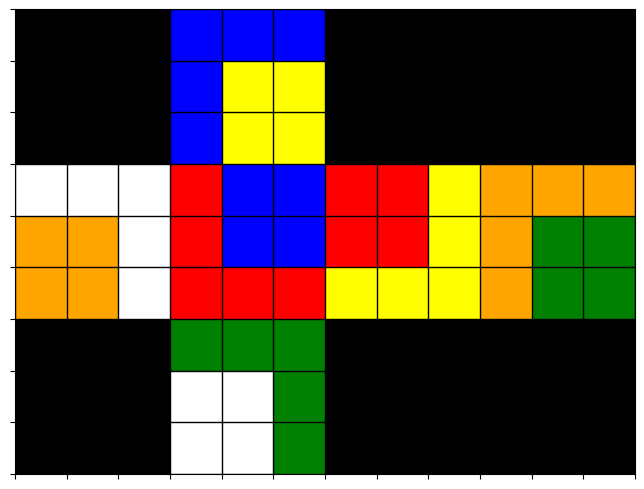

In [22]:
showCube(turn(cube, movements = "F L F U' R U F2 L2 U' L' B D' B' L2 U"))

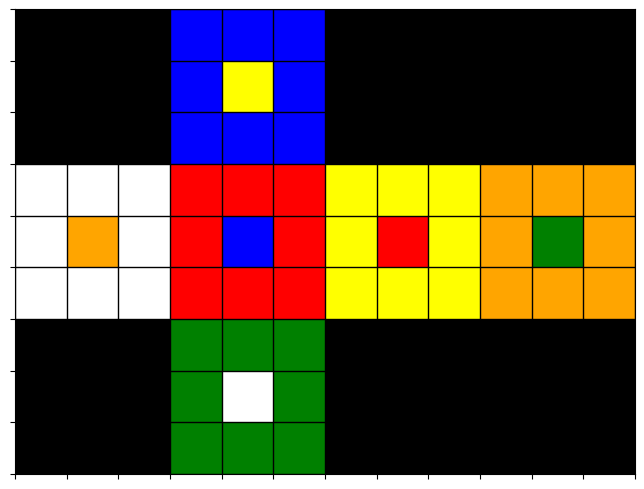

In [23]:
showCube(turn(cube, movements = "U D' R L' F B' U D'"))

# **Utility Functions**

## **State as Sequence of K Movements**

### **Function 1: Fraction of correct colors**

In [24]:
def fractionCorrectColors(cube: np.ndarray, referenceCube: np.ndarray):
    totalCorrect = 0
    for face in FACES:
        faceColors = cube[face]
        referenceFaceColors = referenceCube[face]
        faceCorrectColorsCount = (faceColors == referenceFaceColors).sum()
        totalCorrect += faceCorrectColorsCount
    score = 1 - (totalCorrect - 6) / (9*6 - 6)
    return score

### **Function 2: Weighted fraction of correct cubies**

In [25]:
def weightedFractionWrongCubies(cube: np.ndarray, referenceCube: np.ndarray, cornerWeight: int = 1, borderWeight: int = 1):
    totalWrong = 0
    for cubieFaces in ALL_CUBIES.values():
        isWrong = False
        for face, i, j in cubieFaces:
            cubieFaceColor = cube[face, i, j]
            referenceFaceColor = referenceCube[face, i, j]
            if cubieFaceColor != referenceFaceColor:
                isWrong = True
                break
        if isWrong:
            weight = cornerWeight if len(cubieFaces) == 3 else borderWeight
            totalWrong += weight
    normalizationConstant = 8 * cornerWeight + 12 * borderWeight
    score = totalWrong / normalizationConstant
    return score

### **Function 3: Total shortest movements to independently fix all cubies positions**

In [26]:
# TODO: This function is not working as expected. I need to revisit it.
# def totalIndependentMomentes(cube: np.ndarray, referenceCube: np.ndarray):
#     referenceColors2Coordinates = {
#         tuple(sorted([int(referenceCube[cubieFace]) for cubieFace in cubieFaces])): cubieCoord for cubieCoord, cubieFaces in ALL_CUBIES.items()
#     }
#     coordinates2Colors = {
#         cubieCoord: tuple(sorted([int(cube[cubieFace]) for cubieFace in cubieFaces])) for cubieCoord, cubieFaces in ALL_CUBIES.items()
#     }
#     totalIndependentMovements = 0
#     for cubieCoordinate, cubieColors in coordinates2Colors.items():
#         cubieCoordinate = np.array(cubieCoordinate)
#         referenceCubieCoordinate = np.array(referenceColors2Coordinates[cubieColors])
#         # TODO: We needed to divide by 2, but I need to double check and explain the reason for that (there are 1 cubie between two potential locations that a given cubie can occupy.)
#         delta = (referenceCubieCoordinate - cubieCoordinate)/2
#         manhattanDistance = np.linalg.norm(delta, ord = 1)
#         totalIndependentMovements += manhattanDistance
#     return totalIndependentMovements

### **Function 4: Fraction of correct pairs of cubies**

In [27]:
def fractionWrongCubiePairs(cube: np.ndarray, referenceCube: np.ndarray):
    # TODO: I need to check if this function is working correctly
    totalWrongPairs = 0
    for cubieCoord, cubieFaces in ALL_CUBIES.items():
        cubieFacesCount = len(cubieFaces)
        cubieType = "corner" if cubieFacesCount == 3 else "border" if cubieFacesCount == 2 else "center"
        cubieCoord = np.array(cubieCoord)
        for delta in [(0,0,1), (0,0,-1), (0,1,0), (0,-1,0), (1,0,0), (-1,0,0)]:
            delta = np.array(delta)
            nextCubieCoord = cubieCoord + delta
            nextCubieIsValid = all(np.abs(nextCubieCoord) <= 1)  and any(nextCubieCoord != 0)
            if nextCubieIsValid:
                nextCubieFaces = ALL_CUBIES[tuple(nextCubieCoord)]
                nextCubieFacesCount = len(nextCubieFaces)
                nextCubieType = "corner" if nextCubieFacesCount == 3 else "border" if nextCubieFacesCount == 2 else "center"
                
                # TODO: This is not totally correct because I need to consider the orientations of the cubies
                allColors = [cube[face] for face in cubieFaces]
                allColors += [cube[face] for face in nextCubieFaces]
                allColors = set(allColors)
                allColorsCount = len(allColors)

                if cubieType == "corner" and allColorsCount > 3:
                    totalWrongPairs += 1
                
                elif cubieType == "border" and nextCubieType > "corner" and allColorsCount > 3:
                    totalWrongPairs += 1
                
                elif cubieType == "border" and nextCubieType == "center" and allColorsCount > 2:
                    totalWrongPairs += 1
                
                elif cubieType == "center" and allColorsCount > 2:
                    totalWrongPairs += 1

    normalizationConstant = 8 * 3 + 12 * 4 + 6 * 4
    return totalWrongPairs/normalizationConstant

### **Function 5: Total correct edges (two corner cubies + 1 border cubie)**

In [28]:
borderCubieCoord, borderCubieFaces = [*BORDER_CUBIES.items()][0]
targetCoord = borderCubieCoord.index(0)
delta = [np.zeros(3), np.zeros(3)]
delta[0][targetCoord] = 1
delta[1][targetCoord] = -1

borderCubieCoord = np.array(borderCubieCoord)

neighborCornerCubiesCoord = [borderCubieCoord + v for v in delta]
borderCubieFaceColors = {face[0]: cube[face] for face in borderCubieFaces}
borderCubieFaceColors

{1: 1.0, 2: 2.0}

In [29]:
def totalCorrectEdges(cube: np.ndarray, referenceCube: np.ndarray = None):
    totalCorrect = 0

    for borderCubieCoord, borderCubieFaces in BORDER_CUBIES.items():
        targetCoord = borderCubieCoord.index(0)
        delta = [np.zeros(3), np.zeros(3)]
        delta[0][targetCoord] = 1
        delta[1][targetCoord] = -1

        borderCubieCoord = np.array(borderCubieCoord)
        borderCubieFaceColors = {face[0]: cube[face] for face in borderCubieFaces}

        neighborCornerCubiesCoord = [borderCubieCoord + v for v in delta]
        
        isCorrect = True
        for neighborCubieCoord in neighborCornerCubiesCoord:
            neighborCubieFaces = CORNER_CUBIES[tuple(neighborCubieCoord)]
            neighborCubieFaceColors = {face[0]: cube[face] for face in neighborCubieFaces}
            for face in borderCubieFaceColors:
                if borderCubieFaceColors[face] != neighborCubieFaceColors[face]:
                    isCorrect = False
                    break
        
        if isCorrect:
            totalCorrect += 1

    return totalCorrect         

In [30]:
def evaluateState(state: str, initialCube, referenceCube, utilityMultFactor, utilityFunc, **kwargs):
    movements = state
    cube = turn(initialCube, movements = movements)
    score = utilityFunc(cube, referenceCube, **kwargs)
    return score*utilityMultFactor

# **Transitions**

In [31]:
def kLengthMovementNeighbors(state: str):
    allowedMovements = ["R", "L", "F", "B", "U", "D"]
    allowedMovements += ["R'", "L'", "F'", "B'", "U'", "D'"]
    allowedMovements += ["R2", "L2", "F2", "B2", "U2", "D2"]
    
    movements = state.split(" ")
    movementIndex = np.random.choice(range(len(movements)), 1)[0]
    neighbors = []
    for newMovement in allowedMovements:
        neighbors.append([*movements])
        neighbors[-1][movementIndex] = newMovement
        neighbors[-1] = " ".join(neighbors[-1])

    totalNeighbors = len(neighbors)
    probabilities = np.array([1/totalNeighbors for i in range(totalNeighbors)])
    result = {
        neighbor: probability for neighbor, probability in zip(neighbors, probabilities)
    }
    return result

In [32]:
# TODO: Corrigir erro devido à existência de pares de estados (i,j) onde j é vizinho de i, mas i não é vizinho de j. Como ficaria o cálculo da probabilidade de aceitação?
def atMostKMovementNeighbors(state: str):
    allowedMovements = ["X"]
    allowedMovements += ["R", "L", "F", "B", "U", "D"]
    allowedMovements += ["R'", "L'", "F'", "B'", "U'", "D'"]
    allowedMovements += ["R2", "L2", "F2", "B2", "U2", "D2"]
    
    allMovements = state.split(" ")
    totalAllMovements = len(allMovements)
    
    neighbors = []
    for movementIndex in range(totalAllMovements):
        for newMovement in allowedMovements:
            neighbors.append([*allMovements])
            neighbors[-1][movementIndex] = newMovement
            neighbors[-1] = " ".join(neighbors[-1])
    neighbors = list(set(neighbors))

    totalNeighbors = len(neighbors)
    probabilities = np.array([1/totalNeighbors for i in range(totalNeighbors)])
    result = {
        neighbor: probability for neighbor, probability in zip(neighbors, probabilities)
    }
    return result

In [33]:
# TODO: Permitir que sejam desfeitos os últimos movimentos. Atualmente, permito apenas que o último movimento seja desfeito, pois não sei como calcular a probabilidade de aceitação quando existem pares de estados (i,j) onde j é vizinho de i, mas i não é vizinho de j.
def sequentialMovementNeighbors(state: str, sampleStrategy = "uniform"):
    allowedMovements = ["R", "L", "F", "B", "U", "D"]
    allowedMovements += ["R'", "L'", "F'", "B'", "U'", "D'"]
    allowedMovements += ["R2", "L2", "F2", "B2", "U2", "D2"]

    allMovements = state.split(" ")
    numAllMovements = len(allMovements)

    nonIdleMovements = [movement for movement in allMovements if movement != "X"]
    numNonIdleMovements = len(nonIdleMovements)
    
    if numNonIdleMovements == numAllMovements: # All movements are different than "X"
        movementIndex = -1
        allowedMovements = []

    elif numNonIdleMovements == 0: # All movements are "X"
        movementIndex = 0
    
    else: 
        movementIndex = numNonIdleMovements

    neighbors = []
    for newMovement in allowedMovements:
        neighbors.append([*nonIdleMovements, *["X" for i in range(numAllMovements - numNonIdleMovements)]])
        neighbors[-1][movementIndex] = newMovement
        neighbors[-1] = " ".join(neighbors[-1])
    
    for i in range(numNonIdleMovements-1, numNonIdleMovements):
        neighbors.append([*nonIdleMovements[:i], *["X" for i in range(numAllMovements - i)]])
        neighbors[-1] = " ".join(neighbors[-1])

    if sampleStrategy == "uniform":
        probabilities = [1 for neighbor in neighbors]
    elif sampleStrategy == "prioritize-new-movements":
        probabilities = [numAllMovements - len(re.findall(r"X", neighbor)) + 1 for neighbor in neighbors]
    else: 
        raise ValueError("Sample strategy should be either 'uniform' or 'prioritize-new-movemnts'")
    probabilities = np.array(probabilities)/np.sum(probabilities)
    result = {
        neighbor: probability for neighbor, probability in zip(neighbors, probabilities)
    }
    return result

# **Simulated Annealing**

In [34]:
def simulatedAnnealing(s0, neighborsFunc, utilityFunc, t0: float = 1000, tolerance = 0.0001, strategy = "exponential", beta = 0.9):
    t = t0
    currentState = s0
    currentScore = utilityFunc(currentState)
    bestState = currentState
    bestScore = currentScore
    while t > tolerance:
        currentStateNeighbors = neighborsFunc(currentState)

        candidateState = np.random.choice(list(currentStateNeighbors.keys()), 1, p = list(currentStateNeighbors.values()))[0]
        candidateScore = utilityFunc(candidateState)

        candidateStateNeighbors = neighborsFunc(candidateState)

        cur2candTransitionProb = currentStateNeighbors[candidateState]
        cand2curTransitionProb = candidateStateNeighbors[currentState]

        acceptanceTerm1 = (currentScore - candidateScore)/t
        acceptanceTerm2 = np.log(cand2curTransitionProb)
        acceptanceTerm3 = np.log(cur2candTransitionProb)

        acceptanceProbability = np.min([0, acceptanceTerm1 + acceptanceTerm2 - acceptanceTerm3])

        if np.random.rand() <= np.exp(acceptanceProbability):
            currentState = candidateState
            currentScore = candidateScore
            if currentScore < bestScore:
                print(currentState, currentScore)
                bestState = currentState
                bestScore = currentScore

        if strategy == "exponential":
            t = t * beta
        elif strategy == "linear":
            t = t - beta
        else:
            raise ValueError("Strategy should be exponential or linear.")
    
    return bestState, bestScore

# **Just for test purposes**

In [ ]:
cube = createSolvedCube()
# shuffledCube = turn(cube, "U' R F' R'")
shuffledCube = turn(cube, "F L F U' R U F2 L2 U' L' B D' B' L2 U")
solutionState, solutionScore = simulatedAnnealing(
    "U D2 R U L2 U L R' D B2 U D2 R U L2 U", 
    lambda state: atMostKMovementNeighbors(state), 
    lambda state: evaluateState(state, shuffledCube, cube, 1, totalCorrectEdges),
    beta = 0.01,
    strategy = "linear",
    t0 = 2000
)
print(solutionState, solutionScore)
showCube(shuffledCube)
showCube(turn(shuffledCube, movements = solutionState))

B' R2 R' B 0.35
B' B R X 0.0
B' B R X 0.0


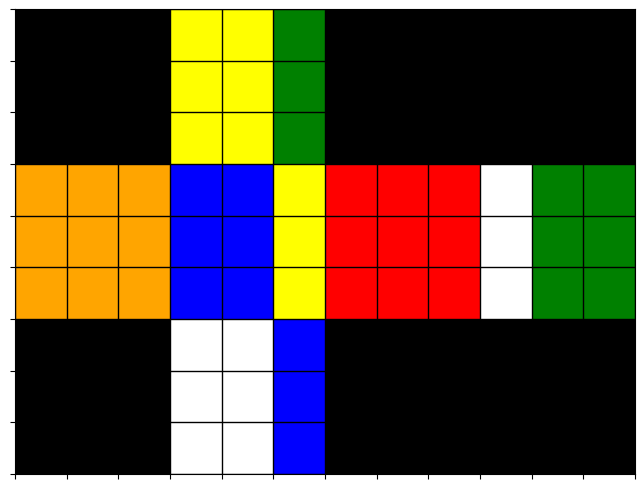

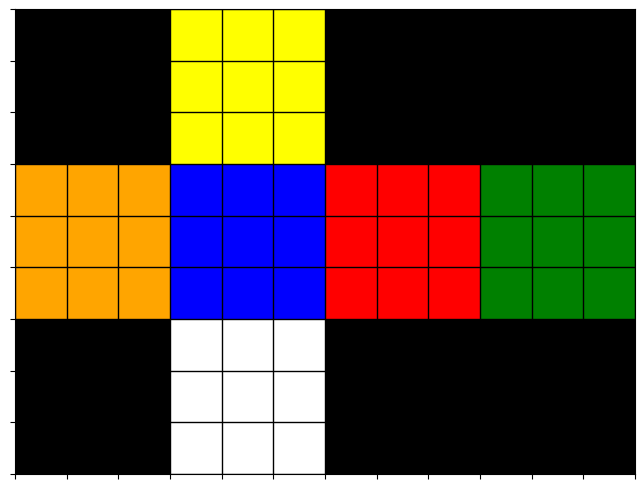

In [76]:
cube = createSolvedCube()
# shuffledCube = turn(cube, "U' R F' R'")
shuffledCube = turn(cube, "F L F U' R U F2 L2 U' L' B D' B' L2 U R' B D' L2 U D R X B' B U U' L2 L2 B X")
solutionState, solutionScore = simulatedAnnealing(
    "X X X X X X X", 
    lambda state: sequentialMovementNeighbors(state, sampleStrategy = "prioritize-new-movements"), 
    lambda state: evaluateState(state, shuffledCube, cube, 1, weightedFractionWrongCubies),
    beta = 0.01,
    strategy = "linear",
    t0 = 1000
)
print(solutionState, solutionScore)
showCube(shuffledCube)
showCube(turn(shuffledCube, movements = solutionState))